# Benchmarking Request Batching for Simple Tasks

This notebook shows benchmark results for request batching and concurrency under simple and structured tasks.


## 1. Benchmark design

- Workload: convert 100 numeric strings to integer literals with `Series.aio.responses`.
- Serial baseline: `batch_size=1` and `max_concurrency=1` send one record per request.
- Request batching: keep `max_concurrency=1` while letting `batch_size` default so multiple records are packed per call.
- Concurrent batching: allow both batching and concurrency to overlap network latency.
- Timing: wall-clock time is measured with `time.perf_counter()` around each invocation; expect variability from model choice, network conditions, and cache warmup.
- Requirements: set `OPENAI_API_KEY` (or the Azure equivalents) and use a lightweight model like `gpt-5.1` to highlight transport overhead instead of model compute.


In [1]:
import time

import pandas as pd

from openaivec import pandas_ext

pandas_ext.set_responses_model("gpt-5.2")

In [2]:
numbers: pd.Series = pd.Series(range(100)).map(str)

In [3]:
numbers

0      0
1      1
2      2
3      3
4      4
      ..
95    95
96    96
97    97
98    98
99    99
Length: 100, dtype: object

In [4]:
duration = {}

In [5]:
start = time.perf_counter()

literal_numbers: pd.Series = await numbers.aio.responses(
    instructions="Convert the following number strings to integer literals.",
    reasoning={"effort": "none"},
    batch_size=1,
    max_concurrency=1
)

duration["serial"] = time.perf_counter() - start

Processing batches:   0%|          | 0/100 [00:00<?, ?item/s]

In [6]:
start = time.perf_counter()

literal_numbers: pd.Series = await numbers.aio.responses(
    instructions="Convert the following number strings to integer literals.",
    reasoning={"effort": "none"},
    # batch_size=1,
    max_concurrency=1
)

duration["batching"] = time.perf_counter() - start

Processing batches:   0%|          | 0/100 [00:00<?, ?item/s]

In [7]:
start = time.perf_counter()

literal_numbers: pd.Series = await numbers.aio.responses(
    instructions="Convert the following number strings to integer literals.",
    reasoning={"effort": "none"},
    # batch_size=1,
    # max_concurrency=1
)

duration["concurrent_batching"] = time.perf_counter() - start

Processing batches:   0%|          | 0/100 [00:00<?, ?item/s]

In [8]:
duration

{'serial': 111.75150470899825,
 'batching': 17.86582645798626,
 'concurrent_batching': 5.927653499995358}

/var/folders/09/9cq3p9sn3hg5s3xc0q87xgth0000gn/T/ipykernel_96270/982876576.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=24)


Text(0.5, 1.0, 'Benchmark Comparison for Simple Task')

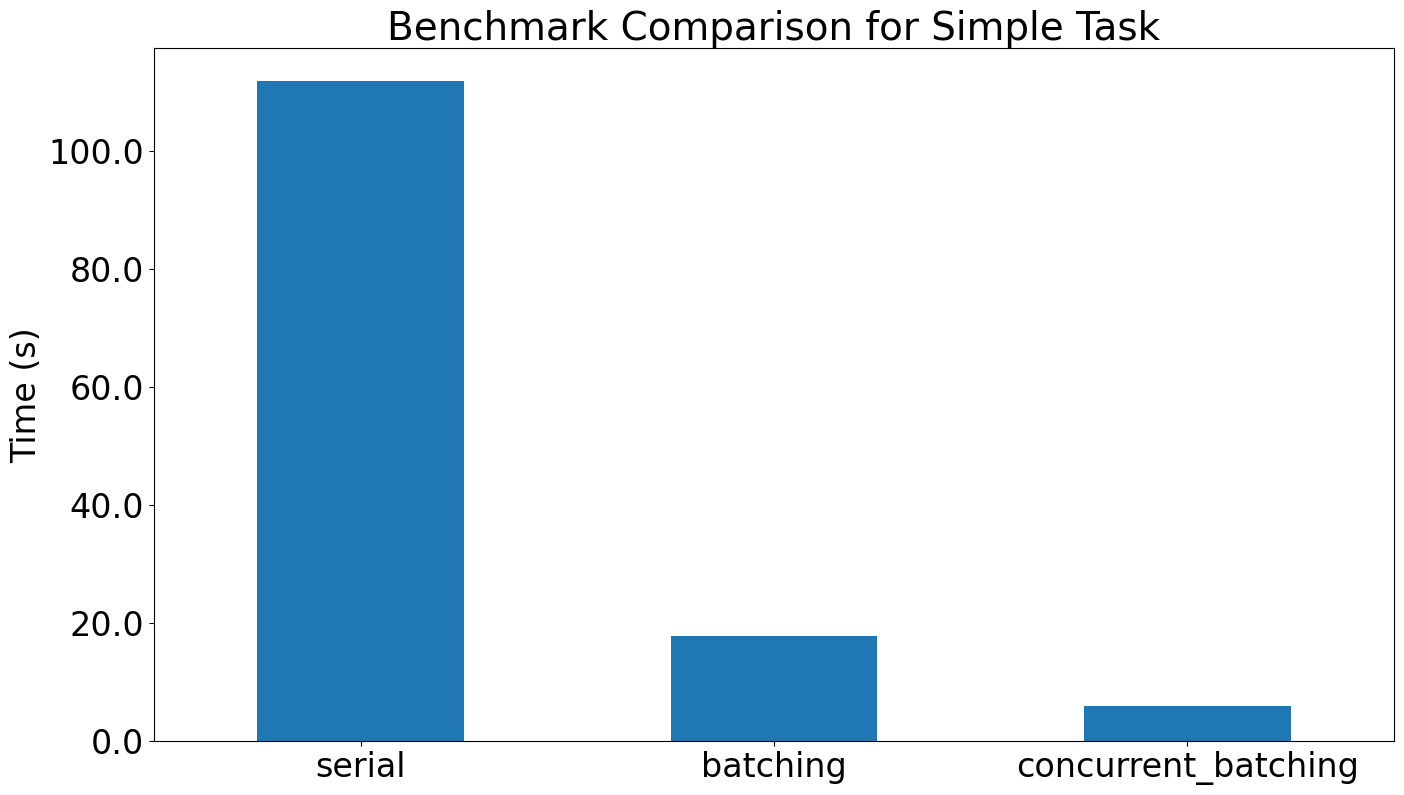

In [9]:
df = pd.DataFrame([duration]).T

ax = df.plot(kind="bar", legend=False, figsize=(16, 9))
ax.set_xticklabels(df.index, rotation=0, fontsize=24)
ax.set_ylabel("Time (s)", fontsize=24)
ax.set_yticklabels(ax.get_yticks(), fontsize=24)
ax.set_title("Benchmark Comparison for Simple Task", fontsize=28)

### Observed timings (number literal task)

- `serial`: ~173 s
- `batching`: ~21 s
- `concurrent_batching`: ~4.7 s

These values come from one run with `gpt-5.1`; reruns will vary with network conditions, but the ordering held.


## 2. Structured sentiment analysis benchmark

We also benchmark a more involved task—classifying customer inquiries with structured JSON output—using the same serial vs batching vs concurrent pattern.


In [10]:
customer_queries: pd.Series = pd.Series(
    [
        "The delivery arrived two days late and the box was damaged.",
        "Love the new dashboard layout—super easy to navigate!",
        "I was charged twice for my order and need help fixing it.",
        "Thanks for the quick response, the issue is resolved.",
        "The app keeps crashing when I try to upload photos.",
        "Shipping updates stopped after the package left the warehouse.",
        "Can I upgrade my plan without downtime?",
        "The replacement part worked perfectly, appreciate the follow-up.",
        "My promo code says expired even though it should be valid.",
        "I'm confused about the billing cycle dates; please clarify.",
        "The live chat disconnected before my question was answered.",
        "Push notifications stopped working after the last update.",
        "Is there a way to export my reports to CSV automatically?",
        "I received the wrong color item and want to exchange it.",
        "The password reset email never arrived.",
        "Our team needs SSO; do you support SAML or OAuth?",
        "The trial expired earlier than the date shown in my account.",
        "I need an invoice that includes our VAT number.",
        "Can you extend the return window by a week?",
        "Search results show duplicates for the same product.",
        "My subscription was canceled without me requesting it.",
        "Dark mode keeps switching back to light mode automatically.",
        "I can't find the toggle to disable marketing emails.",
        "The onboarding tutorial won't progress past step three.",
        "Our firewall blocks your domain; what IPs should we allow?",
        "The loyalty points balance is not updating after purchases.",
        "Checkout keeps declining my card even though it's valid.",
        "How do I merge two accounts that belong to the same user?",
        "The QR code on the packaging doesn't scan.",
        "Attachment uploads fail when the file is over 5 MB.",
        "Where can I download last year's billing statements?",
        "The mobile app logs me out every few hours.",
        "I need to change the shipping address after placing the order.",
        "Your pricing page lists a feature we don't see in our plan.",
        "Calendar sync creates duplicate events in Google Calendar.",
        "The help center article links are returning 404 errors.",
        "Our webhook endpoint isn't receiving any payloads.",
        "Refund was approved but still hasn't hit my bank account.",
        "Captions are out of sync on the training videos.",
        "We need a data processing agreement for compliance.",
        "The barcode scanner misreads certain product labels.",
        "Can I pause my subscription for two months?",
        "Multi-factor authentication codes arrive after they expire.",
        "Why did the app ask for location access after the update?",
        "Team invites are not sending to corporate email addresses.",
        "There's a typo in the shipping address on my label.",
        "I'd like to switch to annual billing to save costs.",
        "The analytics dashboard is missing yesterday's data.",
        "How do I whitelist your email domain to avoid spam filters?",
        "Our CSV import fails without a clear error message.",
        "The temperature sensor reports wildly different readings.",
        "Please cancel order #10432 before it ships.",
        "Is there an API limit for concurrent requests?",
        "Color contrast in the app is hard to read for accessibility.",
        "My referral credit didn't apply at checkout.",
        "Notifications arrive in the wrong timezone.",
        "Can I recover a deleted project from last week?",
        "The product images won't load on Safari.",
        "Where can I see my feature request status?",
        "Bluetooth pairing drops every few minutes.",
        "I was promised free shipping but got charged at checkout.",
        "Our students can't access the course materials after login.",
        "Is there a sandbox environment for testing integrations?",
        "Bulk editing product tags isn't saving changes.",
        "The download link for the desktop app keeps timing out.",
        "Invoice shows the wrong company name; how do I fix it?",
        "I need receipts in PDF instead of HTML emails.",
        "Why was sales tax added even though we're tax-exempt?",
        "Our brand logo looks pixelated in the header.",
        "Keyboard shortcuts stopped working in the editor.",
        "Is offline mode available for field agents?",
        "Two-factor authentication locks me out when traveling.",
        "The chatbot keeps looping and never escalates to a human.",
        "Audio cuts out during video calls after five minutes.",
        "I can't reorder items from my previous purchases.",
        "Please update my shipping speed to express delivery.",
        "Custom domains show SSL certificate errors.",
        "Exported PDFs have truncated paragraphs.",
        "My colleague can't see the shared folder I created.",
        "Is there a way to track package carbon emissions?",
        "Discount disappeared when I added a second item to cart.",
        "App crashes when switching between camera and gallery.",
        "Need guidance on setting up role-based access controls.",
        "Order confirmation email has a broken tracking link.",
        "Voice dictation inserts random punctuation marks.",
        "The battery drains quickly after the firmware update.",
        "Can you provide uptime history for the last quarter?",
        "Gift card balance isn't reflected in my account.",
        "Search bar hides behind the header on mobile view.",
        "Labels printed from your app are misaligned.",
        "Need help migrating data from the legacy portal.",
        "Shipping to my region suddenly shows unavailable.",
        "Custom fields are missing from the API response.",
        "I'd like to disable autoplay on the homepage carousel.",
        "Email templates are stripping out our brand font.",
        "My verification link says it's already expired.",
        "How do I revert to the previous UI until the team adapts?",
        "I want to add a secondary contact for billing approvals.",
        "Data export includes extra blank rows at the end.",
        "The status page showed all green during yesterday's outage.",
    ],
).iloc[:100]

customer_queries


0     The delivery arrived two days late and the box...
1     Love the new dashboard layout—super easy to na...
2     I was charged twice for my order and need help...
3     Thanks for the quick response, the issue is re...
4     The app keeps crashing when I try to upload ph...
                            ...                        
95      My verification link says it's already expired.
96    How do I revert to the previous UI until the t...
97    I want to add a secondary contact for billing ...
98    Data export includes extra blank rows at the end.
99    The status page showed all green during yester...
Length: 100, dtype: object

In [11]:
customer_queries.head()


0    The delivery arrived two days late and the box...
1    Love the new dashboard layout—super easy to na...
2    I was charged twice for my order and need help...
3    Thanks for the quick response, the issue is re...
4    The app keeps crashing when I try to upload ph...
dtype: object

In [12]:
from typing import Literal

from pydantic import BaseModel, Field


class SentimentResponse(BaseModel):
    label: Literal["positive", "neutral", "negative"] = Field(description='positive, neutral, or negative')
    confidence: float = Field(ge=0, le=1, description='Confidence from 0 to 1.')
    rationale: str = Field(description='Brief justification grounded in the inquiry text.')

sentiment_instructions = (
    'You are a customer support QA analyst. '
    'For each inquiry, classify overall sentiment as positive, neutral, or negative. '
    'Return valid JSON with label, confidence (0-1), and a concise rationale grounded in the inquiry.'
)


In [13]:
sentiment_duration = {}


In [14]:
start = time.perf_counter()

sentiment_results: pd.Series = await customer_queries.aio.responses(
    instructions=sentiment_instructions,
    response_format=SentimentResponse,
    reasoning={'effort': 'medium'},
    batch_size=1,
    max_concurrency=1,
)

sentiment_duration['serial'] = time.perf_counter() - start


Processing batches:   0%|          | 0/100 [00:00<?, ?item/s]

In [15]:
start = time.perf_counter()

sentiment_results = await customer_queries.aio.responses(
    instructions=sentiment_instructions,
    response_format=SentimentResponse,
    reasoning={'effort': 'medium'},
    max_concurrency=1,
)

sentiment_duration['batching'] = time.perf_counter() - start


Processing batches:   0%|          | 0/100 [00:00<?, ?item/s]

In [16]:
start = time.perf_counter()

sentiment_results = await customer_queries.aio.responses(
    instructions=sentiment_instructions,
    response_format=SentimentResponse,
    reasoning={'effort': 'medium'},
)

sentiment_duration['concurrent_batching'] = time.perf_counter() - start


Processing batches:   0%|          | 0/100 [00:00<?, ?item/s]

In [17]:
sentiment_duration


{'serial': 190.92683187499642,
 'batching': 77.06497566700273,
 'concurrent_batching': 18.319411333999597}

/var/folders/09/9cq3p9sn3hg5s3xc0q87xgth0000gn/T/ipykernel_96270/1925001372.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=24)


Text(0.5, 1.0, 'Benchmark Comparison for Sentiment Analysis (Structured Output)')

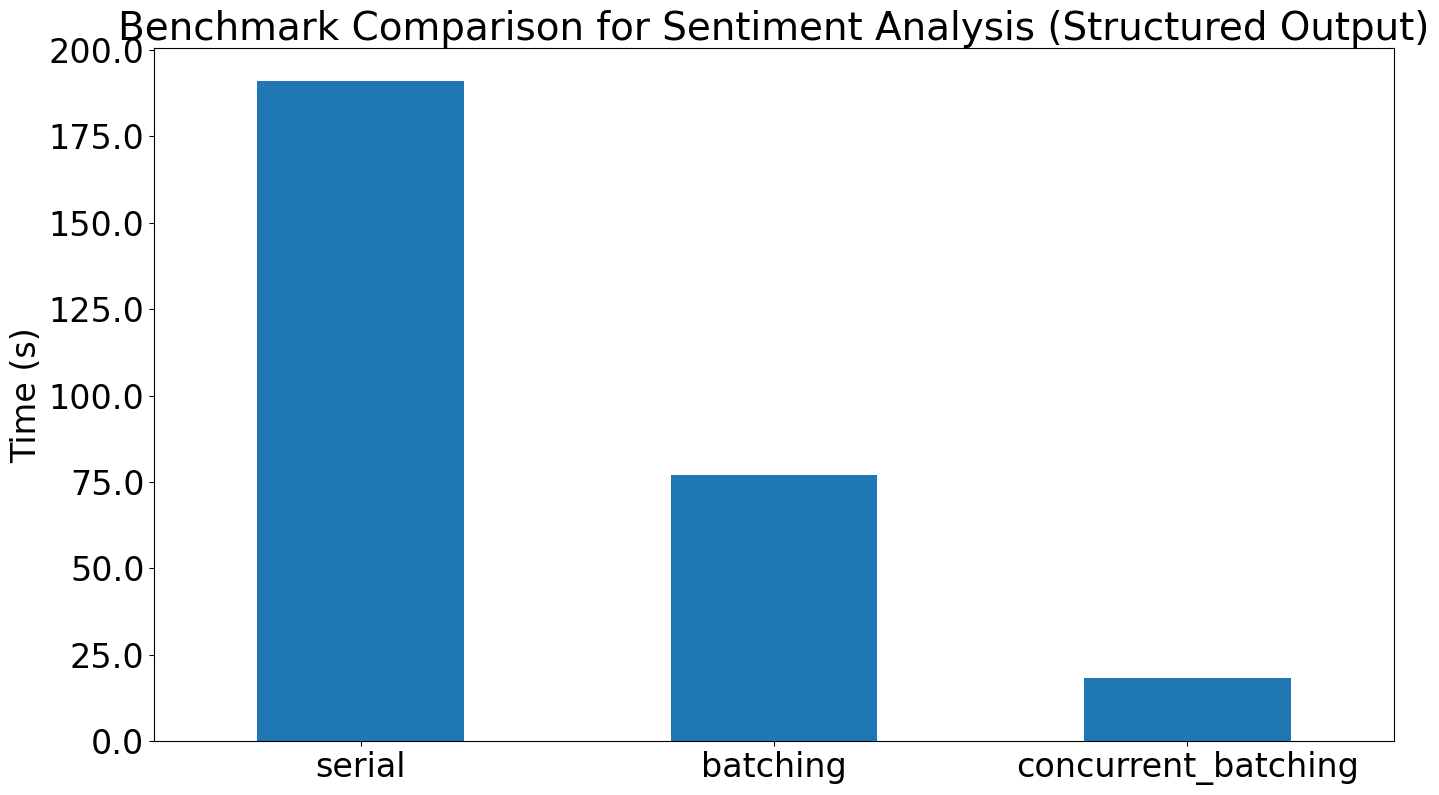

In [18]:
sentiment_df = pd.DataFrame([sentiment_duration]).T

ax = sentiment_df.plot(kind='bar', legend=False, figsize=(16, 9))
ax.set_xticklabels(sentiment_df.index, rotation=0, fontsize=24)
ax.set_ylabel('Time (s)', fontsize=24)
ax.set_yticklabels(ax.get_yticks(), fontsize=24)
ax.set_title('Benchmark Comparison for Sentiment Analysis (Structured Output)', fontsize=28)


### Observed timings (sentiment task)

- `serial`: ~209 s
- `batching`: ~76 s
- `concurrent_batching`: ~16.5 s

Structured output and medium reasoning make the absolute times higher than the simple task, but batching + concurrency still provide the largest gains.


## 3. Reading the results

- Expect `concurrent_batching` to finish first, followed by `batching`, then the fully serial run, because the task does little reasoning and each API round-trip dominates total time.
- Request batching reduces overhead by combining many prompts into a single HTTP call, which is most effective for short, repetitive workloads like this one.
- Adding concurrency overlaps network latency further; tune `max_concurrency` to respect provider rate limits and your own throughput budget.
- Structured workloads (like the sentiment benchmark) add schema validation but show the same ordering; batching still helps even when parsing JSON responses.
- In production pipelines, keep responses deterministic (one output per input) and prefer batching when you need faster turnaround without changing result quality.


## 4. Practical notes

- `Series.aio.responses` batches and deduplicates under the hood, so each input still produces exactly one output; failed batches release any pending requests.
- Keep `batch_size` modest to respect provider limits; batching is most helpful for short, repetitive prompts where HTTP overhead dominates.
- When moving beyond this demo, record both total time and per-item latency to balance throughput with user experience.


In [19]:
sentiment_results.ai.extract()

,label,confidence,rationale
0,negative,0.92,"Reports a late delivery and a damaged box, ind..."
1,positive,0.96,Expresses strong approval of the new dashboard...
2,negative,0.94,"Mentions being charged twice and needing help,..."
3,positive,0.90,Thanks support for a quick response and confir...
4,negative,0.93,States the app keeps crashing during photo upl...
...,...,...,...
95,negative,0.88,Verification link already expired indicates an...
96,neutral,0.70,Asks how to revert to a previous UI; a support...
97,neutral,0.76,Request to add a secondary billing contact is ...
98,negative,0.82,Data export producing extra blank rows is a qu...
